# Fruits Project 


## DataSet overview

## Import Libraries

In [12]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import models

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet50V2



## Global Variables

In [19]:
SEED = 42
BATCH_SIZE = 32 
IMG_SIZE = (224, 224)

### Check GPUs

In [10]:
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load Data

In [20]:
# divide data into train and test and validation sets

def split_data(data_dir, train_dir, test_dir, val_dir, train_size=0.7, val_size=0.2):
    """
    Splits the data into train, test, and validation sets.
    
    Args:
        data_dir (str): Directory containing the original dataset.
        train_dir (str): Directory to save the training set.
        test_dir (str): Directory to save the test set.
        val_dir (str): Directory to save the validation set.
        train_size (float): Proportion of data to use for training.
        val_size (float): Proportion of data to use for validation.
    """
    # Create directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Get all files in the original dataset directory
    all_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]

    # Shuffle the files randomly
    np.random.seed(SEED)
    np.random.shuffle(all_files)

    # Calculate split indices
    total_files = len(all_files)
    train_end = int(train_size * total_files)
    val_end = int((train_size + val_size) * total_files)

    # Split files into train, test, and validation sets
    train_files = all_files[:train_end]
    val_files = all_files[train_end:val_end]
    test_files = all_files[val_end:]

    # Move files to their respective directories
    for file in train_files:
        src_path = os.path.join(data_dir, file)
        dst_path = os.path.join(train_dir, file)
        os.rename(src_path, dst_path)

    for file in val_files:
        src_path = os.path.join(data_dir, file)
        dst_path = os.path.join(val_dir, file)
        os.rename(src_path, dst_path)

    for file in test_files:
        src_path = os.path.join(data_dir, file)
        dst_path = os.path.join(test_dir, file)
        os.rename(src_path, dst_path)


# Example usage
data_dir = "fruits-360"
train_dir = "fruits-360/Training"
test_dir = "fruits-360/Test"
val_dir = "fruits-360/Val"
split_data(data_dir, train_dir, test_dir, val_dir, train_size=0.7, val_size=0.2)


# Load the dataset
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)
val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 102536 files belonging to 200 classes.
Found 0 files belonging to 0 classes.


ValueError: No images found in directory fruits-360/Val. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [9]:
train_ds = image_dataset_from_directory(
    "fruits-360/Training",
    image_size=(128, 128),
    batch_size=32,
    shuffle=True,
    label_mode='categorical',
)

test_ds = image_dataset_from_directory(
    "fruits-360/Test",
    image_size=(128, 128),
    batch_size=32,
    shuffle=False,
    seed= SEED,
    label_mode='categorical',
)



Found 102536 files belonging to 200 classes.
Found 34230 files belonging to 200 classes.


In [6]:
train_ds.class_names

['Apple 10',
 'Apple 11',
 'Apple 12',
 'Apple 13',
 'Apple 14',
 'Apple 17',
 'Apple 18',
 'Apple 19',
 'Apple 5',
 'Apple 6',
 'Apple 7',
 'Apple 8',
 'Apple 9',
 'Apple Braeburn 1',
 'Apple Core 1',
 'Apple Crimson Snow 1',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith 1',
 'Apple Pink Lady 1',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious 1',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apple Rotten 1',
 'Apple hit 1',
 'Apple worm 1',
 'Apricot 1',
 'Avocado 1',
 'Avocado Black 1',
 'Avocado Green 1',
 'Avocado ripe 1',
 'Banana 1',
 'Banana 3',
 'Banana Lady Finger 1',
 'Banana Red 1',
 'Beans 1',
 'Beetroot 1',
 'Blackberrie 1',
 'Blackberrie 2',
 'Blackberrie half rippen 1',
 'Blackberrie not rippen 1',
 'Blueberry 1',
 'Cabbage red 1',
 'Cabbage white 1',
 'Cactus fruit 1',
 'Cactus fruit green 1',
 'Cactus fruit red 1',
 'Caju seed 1',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula 1',
 'Carrot 1',
 'Cauliflower 1',
 '

2025-05-18 16:46:55.653784: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


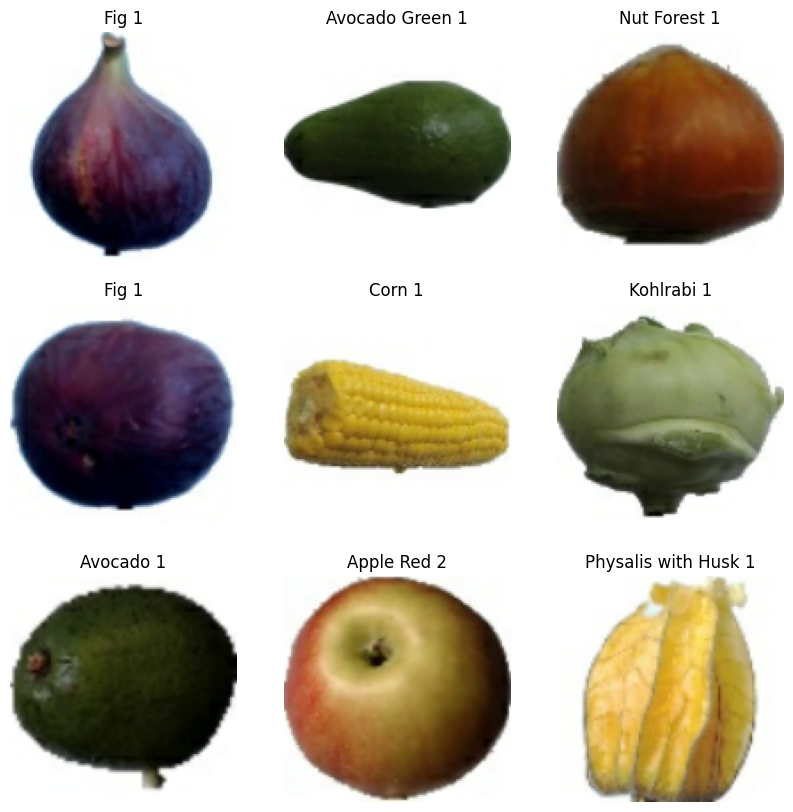

In [5]:
# Display the first 9 images in the training set and their labels
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")